# Análise de Sentimentos

### Carregando Pacotes e Dependências

In [1]:
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, PCA
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import BinaryClassificationEvaluator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (15, 10)

### Carregando Dados

In [2]:
spark = SparkSession.builder.appName('Sentiment Analysis').getOrCreate()
data = spark.read.csv('gs://data-fest-proc/zones/transient_zone/sentiment_analysis.csv', header=True).cache()
dataset = data.select(data.text, data.label.cast('float').alias('label')).cache()
print('%d records found' % (dataset.count()))

1000 records found


### Dados Carregados

In [3]:
dataset.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|So there is no wa...|  0.0|
|Good case Excelle...|  1.0|
|Great for the jaw...|  1.0|
|Tied to charger f...|  0.0|
|    The mic is great|  1.0|
+--------------------+-----+
only showing top 5 rows



### Balanceamento do Dataset

In [4]:
dataset.groupBy('label').agg(count('text').alias('count')).show(5, truncate=False)

+-----+-----+
|label|count|
+-----+-----+
|1.0  |500  |
|0.0  |500  |
+-----+-----+



### Extraíndo Tokens

In [5]:
regex_tokenizer = RegexTokenizer(inputCol='text', outputCol='words', pattern='\\W')
tokenized = regex_tokenizer.transform(dataset)

### Removendo Stop Words

In [6]:
stop_words = ['to','of','it','I','the','is','up','has','have','yet','a','as','this']
words_remover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stop_words)
removed = words_remover.transform(tokenized)

### Extraíndo Características

In [7]:
removed.show(5)

+--------------------+-----+--------------------+--------------------+
|                text|label|               words|            filtered|
+--------------------+-----+--------------------+--------------------+
|So there is no wa...|  0.0|[so, there, is, n...|[so, there, no, w...|
|Good case Excelle...|  1.0|[good, case, exce...|[good, case, exce...|
|Great for the jaw...|  1.0|[great, for, the,...|[great, for, jawb...|
|Tied to charger f...|  0.0|[tied, to, charge...|[tied, charger, f...|
|    The mic is great|  1.0|[the, mic, is, gr...|        [mic, great]|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [8]:
count_vectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=2000, minDF=1)
pipeline = Pipeline(stages=[regex_tokenizer, words_remover, count_vectors])
pipeline_model = pipeline.fit(dataset)
data = pipeline_model.transform(dataset)

In [9]:
data.select('features', 'label').show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1875,[3,10,24,42...|  0.0|
|(1875,[13,36,45,2...|  1.0|
|(1875,[3,7,514],[...|  1.0|
|(1875,[3,39,72,77...|  0.0|
|(1875,[7,321],[1....|  1.0|
+--------------------+-----+
only showing top 5 rows



### Redução para Análise Visual

In [10]:
pca = PCA(k=2, inputCol='features', outputCol='pca_features')
model = pca.fit(data)

result = model.transform(data).select('pca_features', 'label')
result.show(5, truncate=False)

+-------------------------------------------+-----+
|pca_features                               |label|
+-------------------------------------------+-----+
|[-0.3307782376800808,-0.21512246100417506] |0.0  |
|[-0.0087846588470821,0.027694303184915902] |1.0  |
|[-0.09243021304004427,0.07630901782168982] |1.0  |
|[-0.13219156297743564,0.016125319574926363]|0.0  |
|[-0.02264807009997124,0.03606468312297594] |1.0  |
+-------------------------------------------+-----+
only showing top 5 rows



In [11]:
def extract(row):
    return (row.label, ) + tuple(row.pca_features.toArray().tolist())

pca_data = result.rdd.map(extract).toDF(['label', 'feature_01', 'feature_02'])
pca_data.show(5, truncate=False)

+-----+--------------------+--------------------+
|label|feature_01          |feature_02          |
+-----+--------------------+--------------------+
|0.0  |-0.3307782376800808 |-0.21512246100417506|
|1.0  |-0.0087846588470821 |0.027694303184915902|
|1.0  |-0.09243021304004427|0.07630901782168982 |
|0.0  |-0.13219156297743564|0.016125319574926363|
|1.0  |-0.02264807009997124|0.03606468312297594 |
+-----+--------------------+--------------------+
only showing top 5 rows



In [12]:
X = np.array(pca_data.select('feature_01', 'feature_02').collect()).astype(np.float)
Y = np.array(pca_data.select('label').collect()).ravel().astype(np.float)

print(X.shape)
print(Y.shape)

(1000, 2)
(1000,)


### Visualização Gráfica

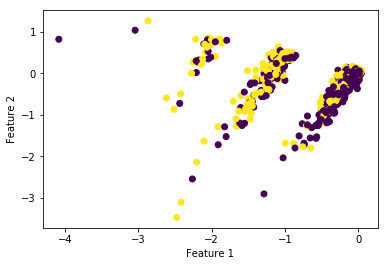

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Separando Dados de Treino e Teste

In [14]:
(train, test) = data.randomSplit([0.7, 0.3], seed=10)

### Ajustando Modelo

In [15]:
classifier = NaiveBayes(smoothing=1, modelType="multinomial")
model = classifier.fit(train)

### Testando Modelo

In [16]:
predictions = model.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print('Accuracy %.3f' % (evaluator.evaluate(predictions)))

Accuracy 0.836


### Matriz de Confusão

In [17]:
vector = np.array(predictions.select("label", "prediction").collect())
pd.crosstab(vector[:,0], vector[:,1])

col_0,0.0,1.0
row_0,,
0.0,109,22
1.0,26,137
